In [162]:
from utils.datasets import get_data, base_novel_categories, split_data
import clip
import torch
clip_model, preprocess = clip.load("RN50")

train_set, val_set, test_set = get_data(data_dir="../cifar10", transform=preprocess)

# split classes into base and novel
base_classes, novel_classes = base_novel_categories(train_set)

# split the three datasets
train_base, train_novel = split_data(train_set, base_classes)
val_base, _ = split_data(val_set, base_classes)
test_base, test_novel = split_data(test_set, base_classes)


In [163]:
from collections import Counter

len(test_novel)
new_test_novel = [sample for sample in test_set if sample[1] in novel_classes[:9]]
print(set(sample[1] for sample in new_test_novel))
counter = Counter([sample[1] for sample in new_test_novel])
print(counter)


{51, 52, 53, 54, 55, 56, 57, 58, 59}
Counter({57: 94, 55: 89, 59: 89, 52: 73, 51: 65, 54: 51, 56: 47, 58: 47, 53: 41})


In [164]:
len(new_test_novel)

596

In [208]:
import torch
from PIL import Image
import umap
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D  # for 3D plot
import clip  # assuming you have already imported and loaded CLIP

# Load CLIP model
device = "cuda" if torch.cuda.is_available() else "mps"
clip_model = clip_model.to(device)

# Initialize storage
image_features = []
targets = []

# Convert the dataset to a list before slicing


# Feature extraction loop
with torch.no_grad():
    for idx, sample in enumerate(new_test_novel):
        image = sample[0].unsqueeze(0).to(device)
        target = sample[1]
        feature = clip_model.encode_image(image).squeeze()
        
        image_features.append(feature)
        targets.append(target)
image_features = torch.stack(image_features)
print(image_features[0].norm())  # Should print ~1.0
image_features = image_features.cpu().numpy()


tensor(1.9653, device='mps:0')


In [209]:
torch.from_numpy(image_features)[0].norm()

tensor(1.9653)

In [210]:
from matplotlib.lines import Line2D
from utils.datasets import CLASS_NAMES
# UMAP with 3D output
reducer = umap.UMAP(n_components=3, n_neighbors=15, min_dist=0.1, metric='cosine')
image_features = reducer.fit_transform(image_features)
image_features = image_features / np.linalg.norm(image_features, axis=1, keepdims=True)



/Users/francescobassignana/miniforge3/envs/deepl/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



In [212]:
np.linalg.norm(image_features, axis=1, keepdims=True)

array([[0.99999994],
       [1.        ],
       [1.        ],
       [0.99999994],
       [1.        ],
       [1.        ],
       [1.        ],
       [0.99999994],
       [1.        ],
       [1.        ],
       [0.99999994],
       [0.99999994],
       [1.        ],
       [0.99999994],
       [0.99999994],
       [0.99999994],
       [1.        ],
       [0.99999994],
       [1.        ],
       [1.        ],
       [1.        ],
       [1.        ],
       [1.        ],
       [1.        ],
       [0.99999994],
       [1.        ],
       [0.99999994],
       [1.        ],
       [1.        ],
       [0.99999994],
       [1.        ],
       [0.99999994],
       [1.        ],
       [1.        ],
       [0.99999994],
       [0.99999994],
       [0.99999994],
       [1.        ],
       [1.        ],
       [0.99999994],
       [1.        ],
       [0.99999994],
       [0.99999994],
       [1.        ],
       [0.99999994],
       [0.99999994],
       [1.        ],
       [0.999

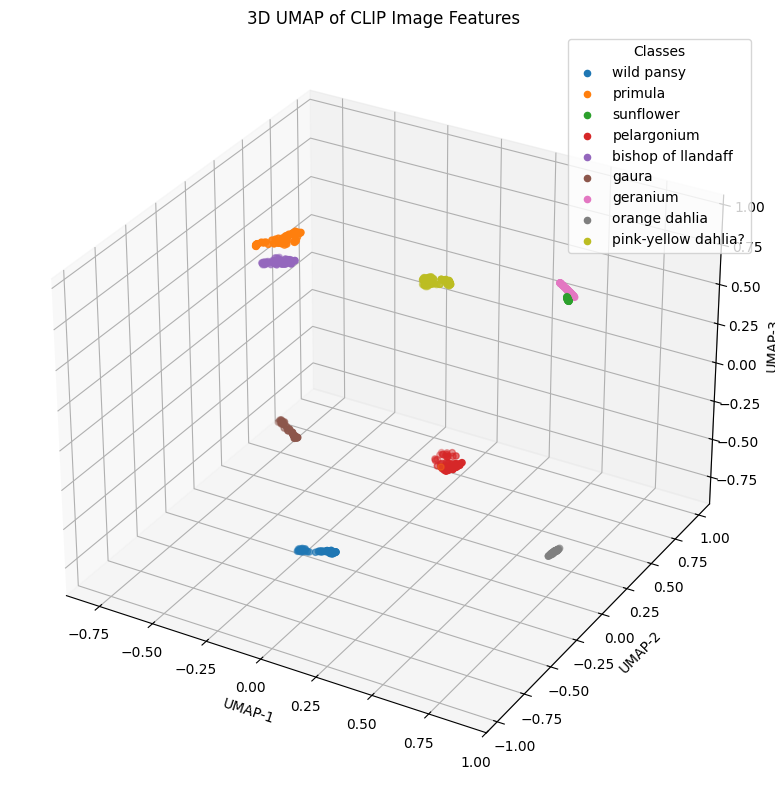

In [211]:
import numpy as np
targets = np.array(targets)
unique_targets = np.unique(targets)
colors = plt.cm.tab10(unique_targets / 10)  # up to 10 classes

# Plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

for i, class_id in enumerate(unique_targets):
    idx = targets == class_id
    ax.scatter(
        image_features[idx, 0],
        image_features[idx, 1],
        image_features[idx, 2],
        s=20,
        color=plt.cm.tab10(i / 10),
        label=CLASS_NAMES[class_id],
        
    )
    

# Legend
ax.legend(title="Classes")
ax.set_title("3D UMAP of CLIP Image Features")
ax.set_xlabel("UMAP-1")
ax.set_ylabel("UMAP-2")
ax.set_zlabel("UMAP-3")
plt.tight_layout()
plt.show()

In [213]:
prompt_labels = [CLASS_NAMES[c] for c in unique_targets]
prompt_labels

['wild pansy',
 'primula',
 'sunflower',
 'pelargonium',
 'bishop of llandaff',
 'gaura',
 'geranium',
 'orange dahlia',
 'pink-yellow dahlia?']

In [214]:
tokens = clip.tokenize(prompt_labels[0]).to(device)
print(tokens)
with torch.no_grad():
    tmp_embedding = clip_model.encode_text(tokens).squeeze().cpu().numpy()
    print(tmp_embedding.shape)

tensor([[49406,  3220,  1072,  2126, 49407,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0]], device='mps:0',
       dtype=torch.int32)
(1024,)


In [215]:
prompt_embeddings = []
for p in prompt_labels:
    tokens = clip.tokenize(p).to(device)
    print(tokens)
    with torch.no_grad():
        tmp_embedding = clip_model.encode_text(clip.tokenize(p).to(device)).squeeze()
        prompt_embeddings.append(tmp_embedding)
        
prompt_embeddings = torch.stack(prompt_embeddings)
print(prompt_embeddings.shape)
prompt_embeddings = prompt_embeddings.cpu().numpy()

prompt_embeddings = reducer.fit_transform(prompt_embeddings)
prompt_embeddings = prompt_embeddings / np.linalg.norm(prompt_embeddings, axis=1, keepdims=True)
    

tensor([[49406,  3220,  1072,  2126, 49407,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0]], device='mps:0',
       dtype=torch.int32)
tensor([[49406,   955, 40937, 49407,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,

/Users/francescobassignana/miniforge3/envs/deepl/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Users/francescobassignana/miniforge3/envs/deepl/lib/python3.10/site-packages/umap/umap_.py:2462: UserWarning:

n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1



In [216]:
np.linalg.norm(prompt_embeddings, axis=1, keepdims=True)

array([[1.        ],
       [1.        ],
       [0.99999994],
       [0.99999994],
       [0.99999994],
       [1.        ],
       [1.        ],
       [1.        ],
       [0.99999994]], dtype=float32)

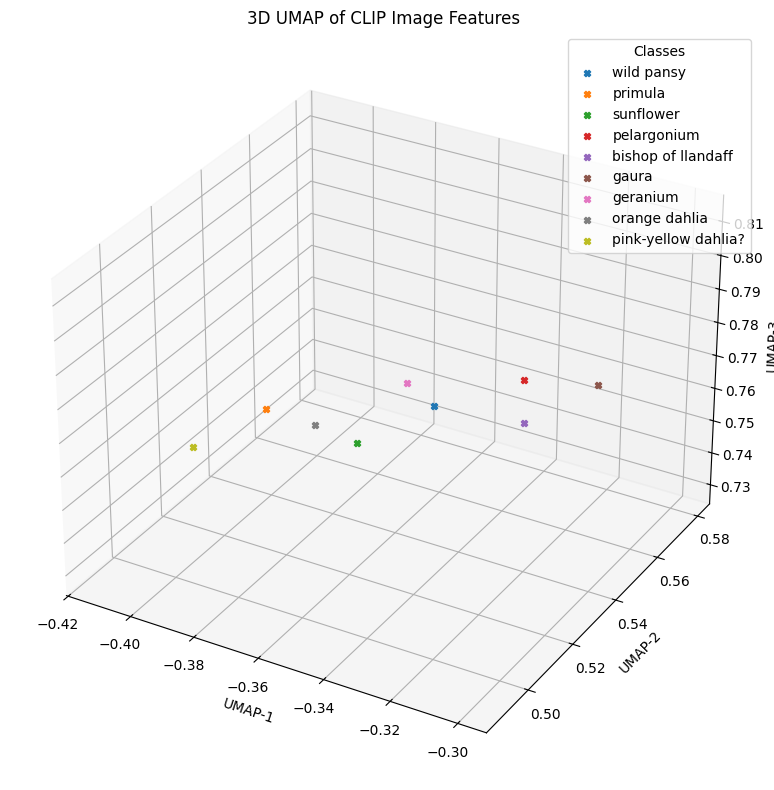

In [217]:

# Plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

for i, emb in enumerate(prompt_embeddings):
    
    ax.scatter(
        emb[0],
        emb[1],
        emb[2],
        s=20,
        color=plt.cm.tab10(i / 10),
        marker="X",
        label=prompt_labels[i]
    )
    


# Legend
ax.legend(title="Classes")
ax.set_title("3D UMAP of CLIP Image Features")
ax.set_xlabel("UMAP-1")
ax.set_ylabel("UMAP-2")
ax.set_zlabel("UMAP-3")
plt.tight_layout()
plt.show()

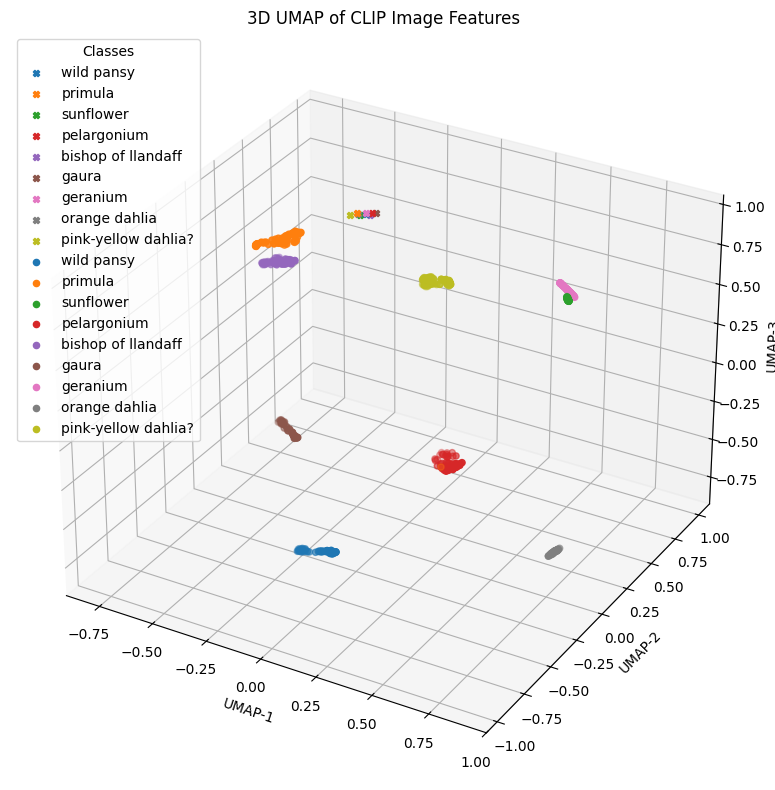

In [218]:

# Plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

for i, emb in enumerate(prompt_embeddings):
    
    ax.scatter(
        emb[0],
        emb[1],
        emb[2],
        s=20,
        color=plt.cm.tab10(i / 10),
        marker="X",
        label=prompt_labels[i]
    )
    

for i, class_id in enumerate(unique_targets):
    idx = targets == class_id
    ax.scatter(
        image_features[idx, 0],
        image_features[idx, 1],
        image_features[idx, 2],
        s=20,
        color=plt.cm.tab10(i / 10),
        label=CLASS_NAMES[class_id]
    )
    
# Legend
ax.legend(title="Classes")
ax.set_title("3D UMAP of CLIP Image Features")
ax.set_xlabel("UMAP-1")
ax.set_ylabel("UMAP-2")
ax.set_zlabel("UMAP-3")
plt.tight_layout()
plt.show()

In [219]:
new_prompt_embeddings = []
template = "a photo of a {}"
prompt_labels_templated = [template.format(prompt_label) for prompt_label in prompt_labels]
for p in prompt_labels_templated:
    tokens = clip.tokenize(p).to(device)
    print(tokens)
    with torch.no_grad():
        tmp_embedding = clip_model.encode_text(clip.tokenize(p).to(device)).squeeze()
        new_prompt_embeddings.append(tmp_embedding)


new_prompt_embeddings = torch.stack(new_prompt_embeddings)
print(new_prompt_embeddings.shape)
new_prompt_embeddings = new_prompt_embeddings.cpu().numpy()

new_prompt_embeddings = reducer.fit_transform(new_prompt_embeddings)
new_prompt_embeddings = new_prompt_embeddings / np.linalg.norm(new_prompt_embeddings, axis=1, keepdims=True)

    

tensor([[49406,   320,  1125,   539,   320,  3220,  1072,  2126, 49407,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0]], device='mps:0',
       dtype=torch.int32)
tensor([[49406,   320,  1125,   539,   320,   955, 40937, 49407,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,

/Users/francescobassignana/miniforge3/envs/deepl/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Users/francescobassignana/miniforge3/envs/deepl/lib/python3.10/site-packages/umap/umap_.py:2462: UserWarning:

n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1



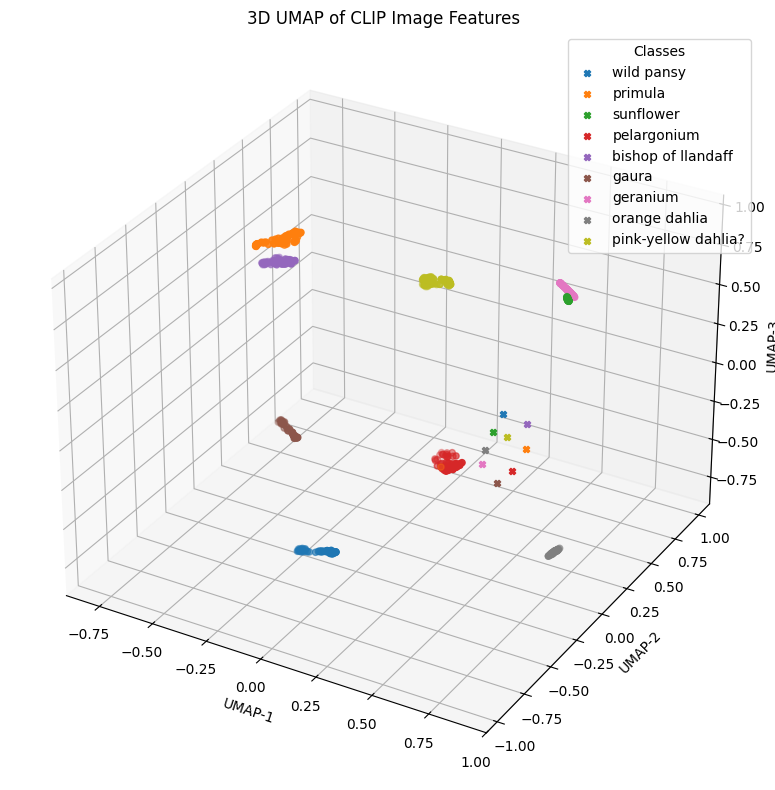

In [220]:

# Plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

for i, emb in enumerate(new_prompt_embeddings):
    
    ax.scatter(
        emb[0],
        emb[1],
        emb[2],
        s=20,
        color=plt.cm.tab10(i / 10),
        marker="X",
        label=prompt_labels[i]
    )
    
ax.legend(title="Classes" , )
for i, class_id in enumerate(unique_targets):
    idx = targets == class_id
    ax.scatter(
        image_features[idx, 0],
        image_features[idx, 1],
        image_features[idx, 2],
        s=20,
        color=plt.cm.tab10(i / 10),
        label=CLASS_NAMES[class_id]
    )
    
# Legend

ax.set_title("3D UMAP of CLIP Image Features")
ax.set_xlabel("UMAP-1")
ax.set_ylabel("UMAP-2")
ax.set_zlabel("UMAP-3")
plt.tight_layout()
plt.show()

In [221]:
prompt_embeddings_center = np.mean(new_prompt_embeddings, axis=0)


image_features_center = np.mean(image_features, axis=0)
image_features_center

array([0.04402874, 0.16215663, 0.2477796 ], dtype=float32)

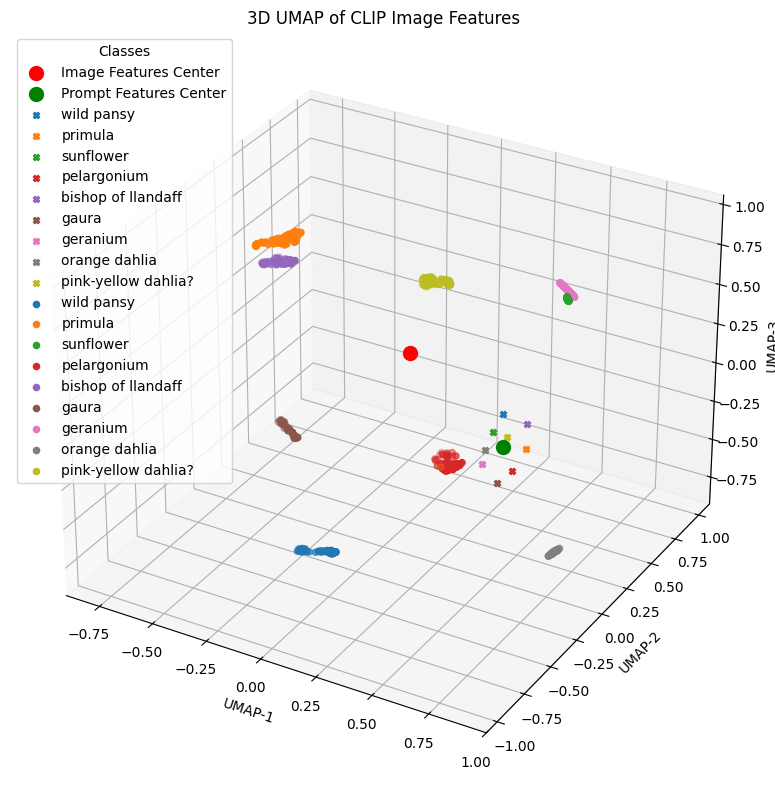

In [222]:
# Plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(
    image_features_center[0],
    image_features_center[1],
    image_features_center[2],
    s=100,
    color="red",
    label="Image Features Center"
)
ax.scatter(
    prompt_embeddings_center[0],
    prompt_embeddings_center[1],
    prompt_embeddings_center[2],
    s=100,
    color="green",
    label="Prompt Features Center"
)


for i, emb in enumerate(new_prompt_embeddings):
    
    ax.scatter(
        emb[0],
        emb[1],
        emb[2],
        s=20,
        color=plt.cm.tab10(i / 10),
        marker="X",
        label=prompt_labels[i]
    )
    

for i, class_id in enumerate(unique_targets):
    idx = targets == class_id
    ax.scatter(
        image_features[idx, 0],
        image_features[idx, 1],
        image_features[idx, 2],
        s=20,
        color=plt.cm.tab10(i / 10),
        label=CLASS_NAMES[class_id]
    )
    
# Legend
ax.legend(title="Classes")
ax.set_title("3D UMAP of CLIP Image Features")
ax.set_xlabel("UMAP-1")
ax.set_ylabel("UMAP-2")
ax.set_zlabel("UMAP-3")
plt.tight_layout()
plt.show()

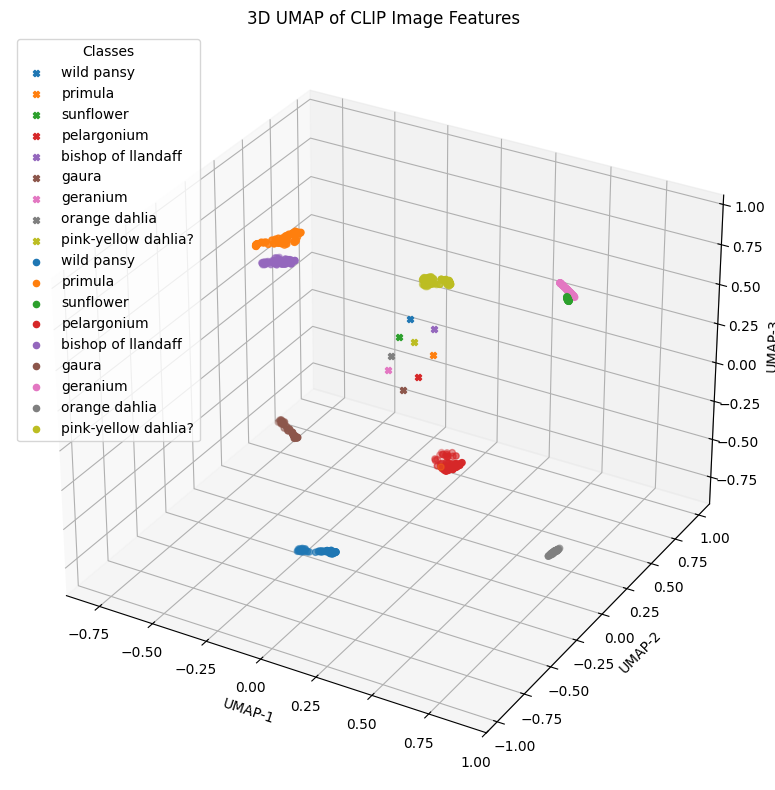

In [223]:
d_means =  prompt_embeddings_center - image_features_center
shifted_prompt_emb = new_prompt_embeddings - d_means
# Plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')


for i, emb in enumerate(shifted_prompt_emb):
    
    ax.scatter(
        emb[0],
        emb[1],
        emb[2],
        s=20,
        color=plt.cm.tab10(i / 10),
        marker="X",
        label=prompt_labels[i]
    )
    

for i, class_id in enumerate(unique_targets):
    idx = targets == class_id
    ax.scatter(
        image_features[idx, 0],
        image_features[idx, 1],
        image_features[idx, 2],
        s=20,
        color=plt.cm.tab10(i / 10),
        label=CLASS_NAMES[class_id]
    )
    
# Legend
ax.legend(title="Classes")
ax.set_title("3D UMAP of CLIP Image Features")
ax.set_xlabel("UMAP-1")
ax.set_ylabel("UMAP-2")
ax.set_zlabel("UMAP-3")
plt.tight_layout()
plt.show()


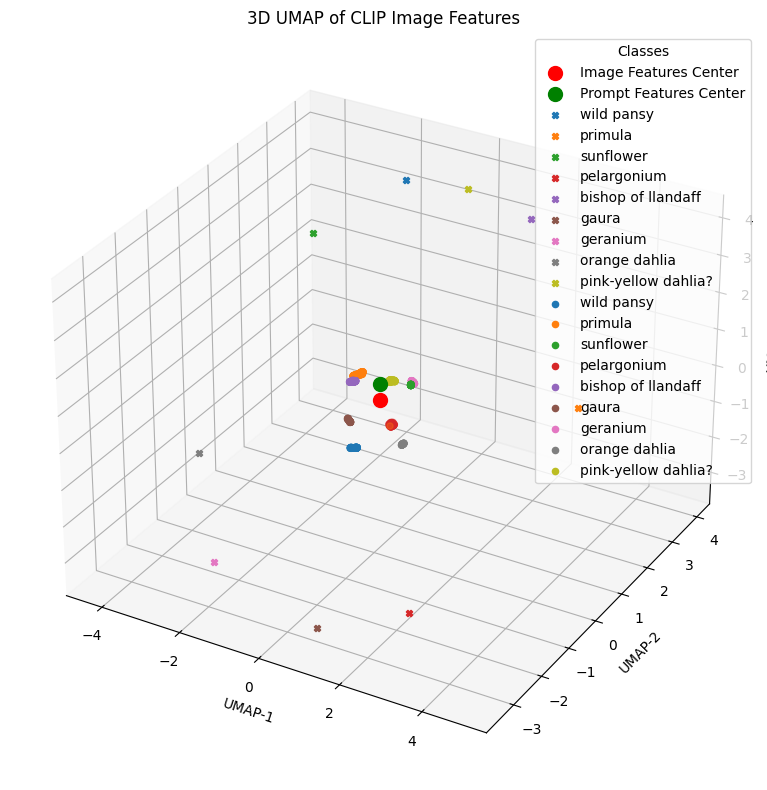

In [224]:

new_center = np.mean(shifted_prompt_emb, axis=0)
# Vector from center to each point
center_distances = np.array(shifted_prompt_emb) - new_center

# Avoid division by zero
norms = np.linalg.norm(center_distances, axis=1, keepdims=True)
norms[norms == 0] = 1e-6

# Unit vectors
versors = center_distances / norms

# Scale and move from the center, not from the original point
K = 5
scaled_prompt_embs = new_center + K * versors

# Plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')


ax.scatter(
    image_features_center[0],
    image_features_center[1],
    image_features_center[2],
    s=100,
    color="red",
    label="Image Features Center"
)

new_centerV2 = np.mean(scaled_prompt_embs, axis=0)
ax.scatter(
    new_centerV2[0],
    new_centerV2[1],
    new_centerV2[2],
    s=100,
    color="green",
    label="Prompt Features Center"
)

for i, emb in enumerate(scaled_prompt_embs):
    
    ax.scatter(
        emb[0],
        emb[1],
        emb[2],
        s=20,
        color=plt.cm.tab10(i / 10),
        marker="X",
        label=prompt_labels[i]
    )
    

for i, class_id in enumerate(unique_targets):
    idx = targets == class_id
    ax.scatter(
        image_features[idx, 0],
        image_features[idx, 1],
        image_features[idx, 2],
        s=20,
        color=plt.cm.tab10(i / 10),
        label=CLASS_NAMES[class_id]
    )
    
# Legend
ax.legend(title="Classes")
ax.set_title("3D UMAP of CLIP Image Features")
ax.set_xlabel("UMAP-1")
ax.set_ylabel("UMAP-2")
ax.set_zlabel("UMAP-3")
plt.tight_layout()
plt.show()


In [225]:
x = torch.tensor([[1,2,3]])
x.size()




torch.Size([1, 3])

In [151]:
x.expand(3,-1)

tensor([[1, 2, 3],
        [1, 2, 3],
        [1, 2, 3]])

In [149]:
x.expand(3,2)

tensor([[1, 1],
        [2, 2],
        [3, 3]])

In [152]:
clip_model.visual.output_dim

1024

In [154]:
len(train_base)


510

In [158]:
Counter([sample[1] for sample in train_base])

Counter({0: 10,
         1: 10,
         2: 10,
         3: 10,
         4: 10,
         5: 10,
         6: 10,
         7: 10,
         8: 10,
         9: 10,
         10: 10,
         11: 10,
         12: 10,
         13: 10,
         14: 10,
         15: 10,
         20: 10,
         16: 10,
         17: 10,
         18: 10,
         19: 10,
         21: 10,
         22: 10,
         23: 10,
         24: 10,
         25: 10,
         26: 10,
         27: 10,
         28: 10,
         29: 10,
         30: 10,
         31: 10,
         32: 10,
         33: 10,
         34: 10,
         35: 10,
         36: 10,
         37: 10,
         38: 10,
         39: 10,
         40: 10,
         41: 10,
         42: 10,
         43: 10,
         44: 10,
         45: 10,
         46: 10,
         47: 10,
         48: 10,
         49: 10,
         50: 10})

In [160]:
c = Counter([sample[1] for sample in test_novel])

In [161]:
len(c)

51